# Algotrading

A pet project aimed at predicting a cryptocurrency price based on data from polymarket.com

## Problem definition


**Meta**: Try to make minimal possible solution & move to more complex ones if a simple one does not perform as we wish it to.

**A goal** is to check whether there is a correlation between crypto currencies (CC) price in the future with & polymarket polls about them.


## Available datapoints are


- CC price from Binance (target)

**Polymarket has polls of varying types**, but at its core, there is a single (Yes/No) bet. Polls of choice type are just an ordered list of (Yes/No) polls.

Some of the polls formats:
- (Choice) Price range prediction of CC at a time point
- (Choice) Min price pred. at a time point
- (Choice) When will a CC reach an all time high
- (Yes/No) Will a CC reach an all time high before some time point
- (Yes/No) Will a CC be above some price at a time point?
- etc.


**Each poll has these datapoints**:
- Total volume in USD
- End date
- For each option to make a bet on, there is a "chance" of it happening, computed using bets distribution.
- How "chance" of an event was changing over time (a graph, chart)
- Price for 100 shares. When placing a bet, user is buying shares. In the UI price per 100 shares is shown. Price of a single share varies between 0 and 1$. When a bet is resolved and user made a winning bet, every share is exchanged to 1$.
- Distribution of how much shares were purchased at what price for each betting option
- Comments on a poll. They can also be replies to top-level comments.
	- Content, text
	- Amount of likes
	- Shares he has on a poll. Note: multiple bets can be placed on a single poll. Total shares amount he has & for which option is shown. It means it is not shown how much money he spent, as share price has a varying price.
- 15 top holders of each option
- Recent activity: who purchased or sold shares and at what cost
- A list of related polls. Potentially, we could extract data from these polls too. For example, for a poll "Bitcoin above $105,000 on January 31?" its related bet can be "Will Bitcoin reach $110_000 by January 31, 2025"

**We can view top users** by their betting volume & profit. **Their bets could be mimiced**.
Looks like a bot to me: https://polymarket.com/profile/0x42a6ddf7cf7032972b0bfe32775e8109c5171b64?tab=activity


## Visual analysis


I've placed 2 charts side my side: BCT Price and Polymarket confidence in BTC hitting a price of $120k by March 31. Visually it can be seen that Polymarket roughly mimics the BTC price trend, which had never reached this price point, typically being in a range of $95k-$105k.

Notably, other polymerket polls - $110k, $130k, $150k, $200k have a similar shape, where bigger the poll price ($200k), less similar (mimicing its up's and down's) it is to a BTC price at that time.

Binance BTC Price Chart            |  Market confidence in "BTC will hit $120k by March 31" 
:-------------------------:|:-------------------------:
![image.png](../static/1_binance_btc_chart.png)  |  ![image.png](../static/1_polymarket_BTC_hit_120k.png)


Next observation is, that polls that bet on a lower outcome than the current price have a negative correlation, meaning that when more people bet "Yes" on $120k, more people vote "No" on $80k.

Market confidence in "BTC will hit $120k by March 31"
![image.png](../static/1_polymarket_BTC_hit_120k.png)  

Market confidence in "BTC will hit $80k by March 31"
![image.png](../static/1_polymarket_BTC_hit_80k.png)


In [ ]:
from binance import Client

api_key = "chZ715f5LtqTMoCr6vSrl16VyWg8PWlQzkFFKLFwWFY0F4b7Wd8c3OugFJgi5PEL"
api_secret = "Ki6RzqUwuByncvkQ2vVaeMaBRicsxYSG7mgfcCANGEG0KaJJM3ffwc2Ya0UBsmuY"
client = Client(api_key, api_secret)

symbol = "BTCUSDT"  # or any other trading pair
interval = Client.KLINE_INTERVAL_1DAY

data = client.get_historical_klines(
    symbol=symbol, interval=interval, start_str="2024-12-13", end_str="2025-02-08"
)

columns = [
    "Open Time", "Open", "High", "Low", "Close", "Volume",
    "Close Time", "Quote Asset Volume", "Number of Trades",
    "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
]

In [11]:
import pandas as pd

df = pd.DataFrame(data, columns=columns)

df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

numeric_columns = ["Open", "High", "Low", "Close", "Volume", "Quote Asset Volume",
                   "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
df[numeric_columns] = df[numeric_columns].astype(float)

df = df.set_index('Open Time')

df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Open Time,,,,,,,,,,,
2024-12-13,100004.29,101895.26,99205.00,101424.25,21904.039230,2024-12-13 23:59:59.999,2.203903e+09,5481660,10669.093650,1.073721e+09,0
2024-12-14,101424.24,102650.00,100609.41,101420.00,14191.703260,2024-12-14 23:59:59.999,1.441594e+09,3374538,6790.246760,6.899819e+08,0
2024-12-15,101420.00,105250.00,101237.14,104463.99,22228.921775,2024-12-15 23:59:59.999,2.290463e+09,3638809,12668.894355,1.305611e+09,0
2024-12-16,104463.99,107793.07,103333.00,106058.66,41302.402740,2024-12-16 23:59:59.999,4.364964e+09,8048054,20349.099500,2.150551e+09,0
2024-12-17,106058.65,108353.00,105321.49,106133.74,29064.936466,2024-12-17 23:59:59.999,3.103833e+09,7212799,14187.320446,1.515158e+09,0


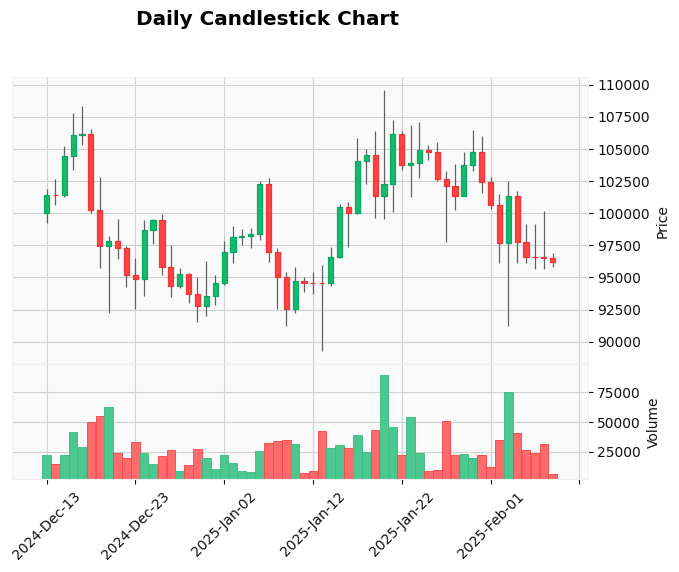

In [12]:
import mplfinance as mpf

mpf.plot(df, type='candle', volume=True, title="Daily Candlestick Chart", style='yahoo')

In [37]:
df["delta"] = df["Close"] - df["Open"]
df[-5:-1]

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,delta
Open Time,,,,,,,,,,,,
2025-02-04,101328.51,101732.31,96150.00,97763.13,40267.98697,2025-02-04 23:59:59.999,3.989699e+09,6618911,19091.58154,1.891457e+09,0,-3565.38
2025-02-05,97763.14,99149.00,96155.00,96612.43,26233.30444,2025-02-05 23:59:59.999,2.562342e+09,4471763,11032.55174,1.078316e+09,0,-1150.71
2025-02-06,96612.44,99120.00,95676.64,96554.35,23515.20405,2025-02-06 23:59:59.999,2.289072e+09,4242807,11261.53049,1.096612e+09,0,-58.09
2025-02-07,96554.35,100137.99,95620.34,96506.80,31794.22065,2025-02-07 23:59:59.999,3.107592e+09,5012456,15249.35370,1.491115e+09,0,-47.55


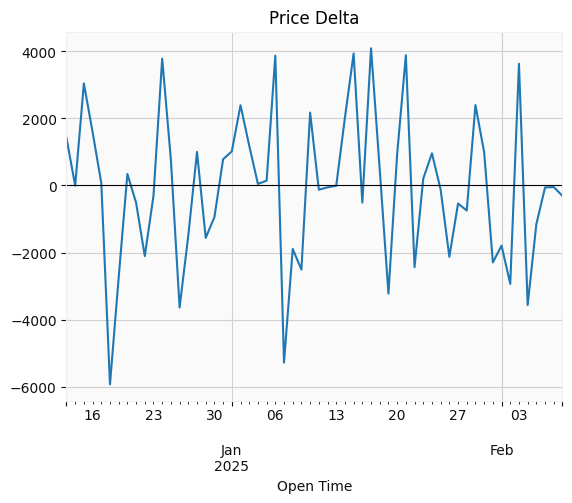

In [ ]:
import matplotlib.pyplot as plt

ax = df['delta'].plot(title='Price Delta')
ax.axhline(0, color='black', linewidth=0.8)
plt.show()

In [101]:
pm_df = pd.read_csv('../data/1_polymarket_BTC_1d.csv')
pm_df['Date (UTC)'] = pd.to_datetime(pm_df['Date (UTC)'])

pm_df = pm_df.set_index('Date (UTC)')
for bet in ['150,000', '120,000', '80,000', '70,000']:
    column = f'${bet}'
    pm_df[f'delta_{bet}'] = pm_df[column].shift(-1).diff()

pm_df.head()

,Timestamp (UTC),"$150,000","$120,000","$80,000","$70,000","delta_150,000","delta_120,000","delta_80,000","delta_70,000"
Date (UTC),,,,,,,,,
2024-12-13,1734048003,0.305,0.625,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-14,1734134403,0.240,0.590,0.410,0.185,-0.005,0.005,0.000,0.06
2024-12-15,1734220803,0.235,0.595,0.410,0.245,0.030,0.070,-0.080,-0.07
2024-12-16,1734307203,0.265,0.665,0.330,0.175,0.040,0.070,0.005,0.01
2024-12-17,1734393604,0.305,0.735,0.335,0.185,0.025,-0.035,-0.015,0.00


<Axes: title={'center': 'Polymarket Delta'}, xlabel='Date (UTC)'>

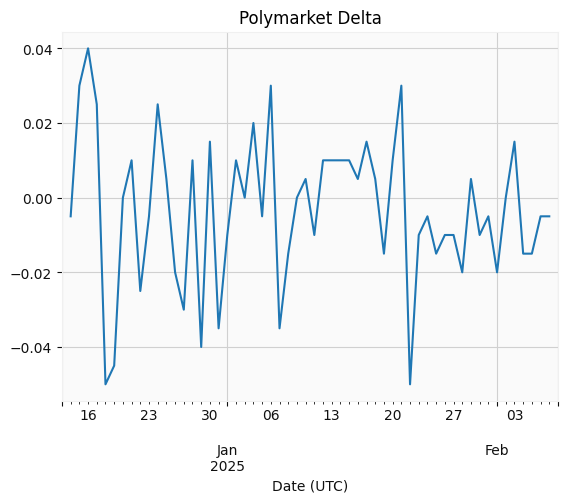

In [104]:
pm_df['delta_150,000'].plot(title='Polymarket Delta')

In [106]:
from sklearn.preprocessing import MinMaxScaler

delta_df = pd.concat([df['delta'], pm_df['delta_150,000']], axis=1)

delta_df.columns = ['BTC_delta', 'delta_150,000']
scaler = MinMaxScaler()
delta_df[['BTC_delta', 'delta_150,000']] = scaler.fit_transform(delta_df[['BTC_delta', 'delta_150,000']])

delta_df.head()

,BTC_delta,"delta_150,000"
2024-12-13,0.733509,NaN
2024-12-14,0.591372,0.500000
2024-12-15,0.895589,0.888889
2024-12-16,0.750945,1.000000
2024-12-17,0.599289,0.833333


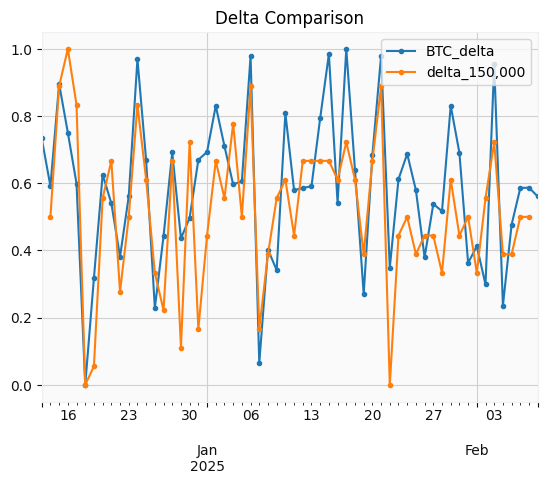

In [107]:
delta_df.plot(style='.-', title='Delta Comparison')
plt.show()

In [109]:
for offset in range(-6, 6):
    shifted_polymarket_delta = delta_df['delta_150,000'].shift(offset)
    correlation_with_offset = delta_df['BTC_delta'].corr(shifted_polymarket_delta)
    print(f"Correlation with offset {offset}: {correlation_with_offset}")

Correlation with offset -6: -0.07040683078687103
Correlation with offset -5: -0.16205822842546716
Correlation with offset -4: 0.13857841735238233
Correlation with offset -3: 0.036131547236175156
Correlation with offset -2: -0.08049649415058292
Correlation with offset -1: 0.11491115763271276
Correlation with offset 0: 0.7228687643774032
Correlation with offset 1: -0.026567652981902255
Correlation with offset 2: -0.2710046064456163
Correlation with offset 3: -0.054350065663052644
Correlation with offset 4: 0.1303645870752861
Correlation with offset 5: -0.16294582563629964
